# Introduction


### About this notebook

#### 1. Data collection
#### 2. Data preprocessing
#### 3. Visualization
#### 4. Apply ARIMA and VARNN model to predict GDP, Inflation,.. 


## 1.1. Data collection

Dữ liệu thu thập từ trang web VBMA - Hiệp hội thị trường trái phiếu Việt Nam https://vbma.org.vn/vi/market-data/macro-economic-heatmap.        
## Dữ liệu chứa thông tin tổng quan kinh tế vĩ mô Việt Nam từ 2017 đến 2023.
## Dưới đây là mô tả chi tiết về các cột trong tập dữ liệu:

### FDI (Foreign Direct Investment)
**FDI đăng ký (lũy kế năm) % YoY**: Đo lường giá trị đầu tư trực tiếp nước ngoài đăng ký so với cùng kỳ năm trước.      
**FDI giải ngân (lũy kế năm) % YoY**: Đo lường giá trị vốn FDI đã giải ngân so với cùng kỳ năm trước.

### Thương mại (lũy kế năm)
**Xuất khẩu (lũy kế năm) % YoY**: Đo lường giá trị hàng hóa và dịch vụ xuất khẩu so với cùng kỳ năm trước.      
**Nhập khẩu (lũy kế năm) % YoY**: Đo lường giá trị hàng hóa và dịch vụ nhập khẩu so với cùng kỳ năm trước.

### Cung tiền & tín dụng
**Tăng trưởng tín dụng % YoY**: Đo lường sự gia tăng tổng giá trị các khoản vay tín dụng so với cùng kỳ năm trước.

### Tài khóa
**Tổng thu % YoY**: Đo lường sự tăng trưởng của tổng thu ngân sách nhà nước so với cùng kỳ năm trước.

### Chỉ số giá
**Lạm phát cơ bản % YoY**: Đo lường sự thay đổi của mức giá tiêu dùng, loại trừ giá thực phẩm và năng lượng so với cùng kỳ năm trước.

### Tăng trưởng GDP thực tế % YoY
**Tăng trưởng GDP thực tế % YoY**: Đo lường sự tăng trưởng của tổng sản phẩm quốc nội (GDP) thực tế so với cùng kỳ năm trước.

In [301]:
# Standard Libraries
import warnings
warnings.filterwarnings("ignore")
import math
from cmath import sqrt

# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Analysis
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Deep Learning
import tensorflow as tf

In [302]:
file_path = 'data/vietnam_macro_economic.csv'
data = pd.read_csv(file_path)
data.head()

,Thời gian,FDI,FDI đăng kí (lũy kế năm),FDI giải ngân (lũy kế năm),Thương mại (lũy kế năm),Xuất khẩu (lũy kế năm),Nhập khẩu (lũy kế năm),Cung tiền & tín dụng,Tăng trưởng tín dụng,Nông nghiệp,...,Chi thường xuyên,Chỉ số giá,Lạm phát cơ bản,Lạm phát,Thực phẩm,Nhà ở và VLXD,Y tế,Vận tải,Chỉ số PMI,Tăng trưởng GDP thực tế
0,-,-,% YoY,% YoY,-,% YoY,% YoY,-,% YoY,% YoY,...,% YoY,-,% YoY,% YoY,% YoY,% YoY,% YoY,% YoY,-,% YoY
1,T1 2017,-,19,6.3,-,6,3.2,-,19.5,17.7,...,NaN,-,1.9,5.2,2.4,3.5,79.4,5,51.9,5.2
2,T2 2017,-,21.5,3.3,-,16.5,23.5,-,19.6,17.5,...,NaN,-,1.5,5,-0.3,4.8,79.8,10,54.2,5.2
3,T3 2017,-,91.5,3.4,-,15.7,25.4,-,21.6,17.9,...,NaN,-,1.6,4.7,-0.9,5.3,48.7,14.6,54.6,5.2
4,T4 2017,-,53.9,3.2,-,17.4,24.8,-,20.6,17.8,...,NaN,-,1.5,4.3,-1.7,4.3,63.6,11.1,54.1,6.4


In [303]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [304]:
data.shape

(85, 29)

## 1.2. Data Preprocessing

### 1.2.1. Clean columns

In [305]:
data.columns

Index(['Thời gian', 'FDI', 'FDI đăng kí (lũy kế năm)',
       'FDI giải ngân (lũy kế năm)', 'Thương mại (lũy kế năm)',
       'Xuất khẩu  (lũy kế năm)', 'Nhập khẩu  (lũy kế năm)',
       'Cung tiền & tín dụng', 'Tăng trưởng tín dụng', 'Nông nghiệp',
       'Thương mại', 'Công nghiệp', 'Xây dựng', 'Cung tiền M2', 'Tài khóa',
       'Tổng thu', 'Nội địa', 'Tổng chi', 'Chi đầu tư phát triển',
       'Chi thường xuyên', 'Chỉ số giá', 'Lạm phát cơ bản', 'Lạm phát',
       'Thực phẩm', 'Nhà ở và VLXD', 'Y tế', 'Vận tải', 'Chỉ số PMI',
       'Tăng trưởng GDP thực tế'],
      dtype='object')

In [306]:
columns = ['Thoi_gian', 'FDI', 'FDI_dang_ki',
       'FDI_giai_ngan', 'Thuong_mai_luy_ke_nam',
       'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te']

data.columns = columns

print("Column names after cleaning:", data.columns)

Column names after cleaning: Index(['Thoi_gian', 'FDI', 'FDI_dang_ki', 'FDI_giai_ngan',
       'Thuong_mai_luy_ke_nam', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam',
       'Cung_tien_va_tin_dung', 'Tang_truong_tin_dung', 'Nong_nghiep',
       'Thuong_mai', 'Cong_nghiep', 'Xay_dung', 'Cung_tien_M2', 'Tai_khoa',
       'Tong_thu', 'Noi_dia', 'Tong_chi', 'Chi_dau_tu_phat_trien',
       'Chi_thuong_xuyen', 'Chi_so_gia', 'Lam_phat_co_ban', 'Lam_phat',
       'Thuc_pham', 'Nha_o_va_VLXD', 'Y_te', 'Van_tai', 'Chi_so_PMI',
       'Tang_truong_GDP_thuc_te'],
      dtype='object')


In [307]:
selected_columns = ['Thoi_gian', 'FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
data = data[selected_columns]

# Drop hàng thứ 2 (hàng chứa thông tin về đơn vị)
data = data.drop(0)

data.head()
data.shape

(84, 8)

### 1.2.2. Convert date format

In [308]:
def convert_date(date_str):
    month_map = {
        'T1': '01', 'T2': '02', 'T3': '03', 'T4': '04', 'T5': '05',
        'T6': '06', 'T7': '07', 'T8': '08', 'T9': '09', 'T10': '10',
        'T11': '11', 'T12': '12'
    }
    month, year = date_str.split()
    month = month_map[month]
    return pd.to_datetime(f'{year}-{month}-01')


time_column = 'Thoi_gian'
data[time_column] = data[time_column].apply(convert_date)

data[time_column] = pd.to_datetime(data[time_column])
data.set_index(time_column, inplace=True)

data.head()

,FDI_dang_ki,Xuat_khau_luy_ke_nam,Nhap_khau_luy_ke_nam,Tang_truong_tin_dung,Cung_tien_M2,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,,,,,
2017-01-01,19,6,3.2,19.5,19.7,5.2,5.2
2017-02-01,21.5,16.5,23.5,19.6,18.1,5,5.2
2017-03-01,91.5,15.7,25.4,21.6,17.7,4.7,5.2
2017-04-01,53.9,17.4,24.8,20.6,17,4.3,6.4
2017-05-01,19.4,19,25.3,22,16.2,3.2,6.4


### 1.2.3. Handle missing value

In [309]:
data.isna().sum()

FDI_dang_ki                0
Xuat_khau_luy_ke_nam       5
Nhap_khau_luy_ke_nam       2
Tang_truong_tin_dung       0
Cung_tien_M2               0
Lam_phat                   0
Tang_truong_GDP_thuc_te    0
dtype: int64

In [310]:
xuat_khau = 'Xuat_khau_luy_ke_nam'
nhap_khau = 'Nhap_khau_luy_ke_nam'

data[xuat_khau] = data[xuat_khau].replace({None: np.nan, '': np.nan})
data[nhap_khau] = data[nhap_khau].replace({None: np.nan, '': np.nan})

data[xuat_khau] = pd.to_numeric(data[xuat_khau], errors='coerce')
data[nhap_khau] = pd.to_numeric(data[nhap_khau], errors='coerce')

# Xử lí những giá trị null trong cột xuất khẩu và nhập khẩu bằng nội suy tuyến tính
data[xuat_khau] = data[xuat_khau].interpolate(method='linear')
data[nhap_khau] = data[nhap_khau].interpolate(method='linear')

missing_values = data.isna().sum()
missing_values[missing_values > 0]
data = data.astype(float)

### 1.2.4. Detect outlier using IsolationForest

In [311]:
model = IsolationForest(n_estimators=100, contamination=0.25)
model.fit(data)
y_anomaly = model.predict(data)
data[y_anomaly == -1] = np.median(data, axis=0)

### 1.2.5. Standardization

In [312]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
data[data.columns] = scaled_data

### 1.2.6. Check stationarity

#### Augmented Dickey-Fuller (ADF) test and visualize the result

- Forest Green: Strong evidence that the series is stationary (ADF statistic is less than the 1% critical value).
- Gold: Moderate evidence that the series is stationary (ADF statistic is less than the 5% critical value).
- Orange: Weak evidence that the series is stationary (ADF statistic is less than the 10% critical value).
- Indian Red: Evidence that the series is non-stationary.

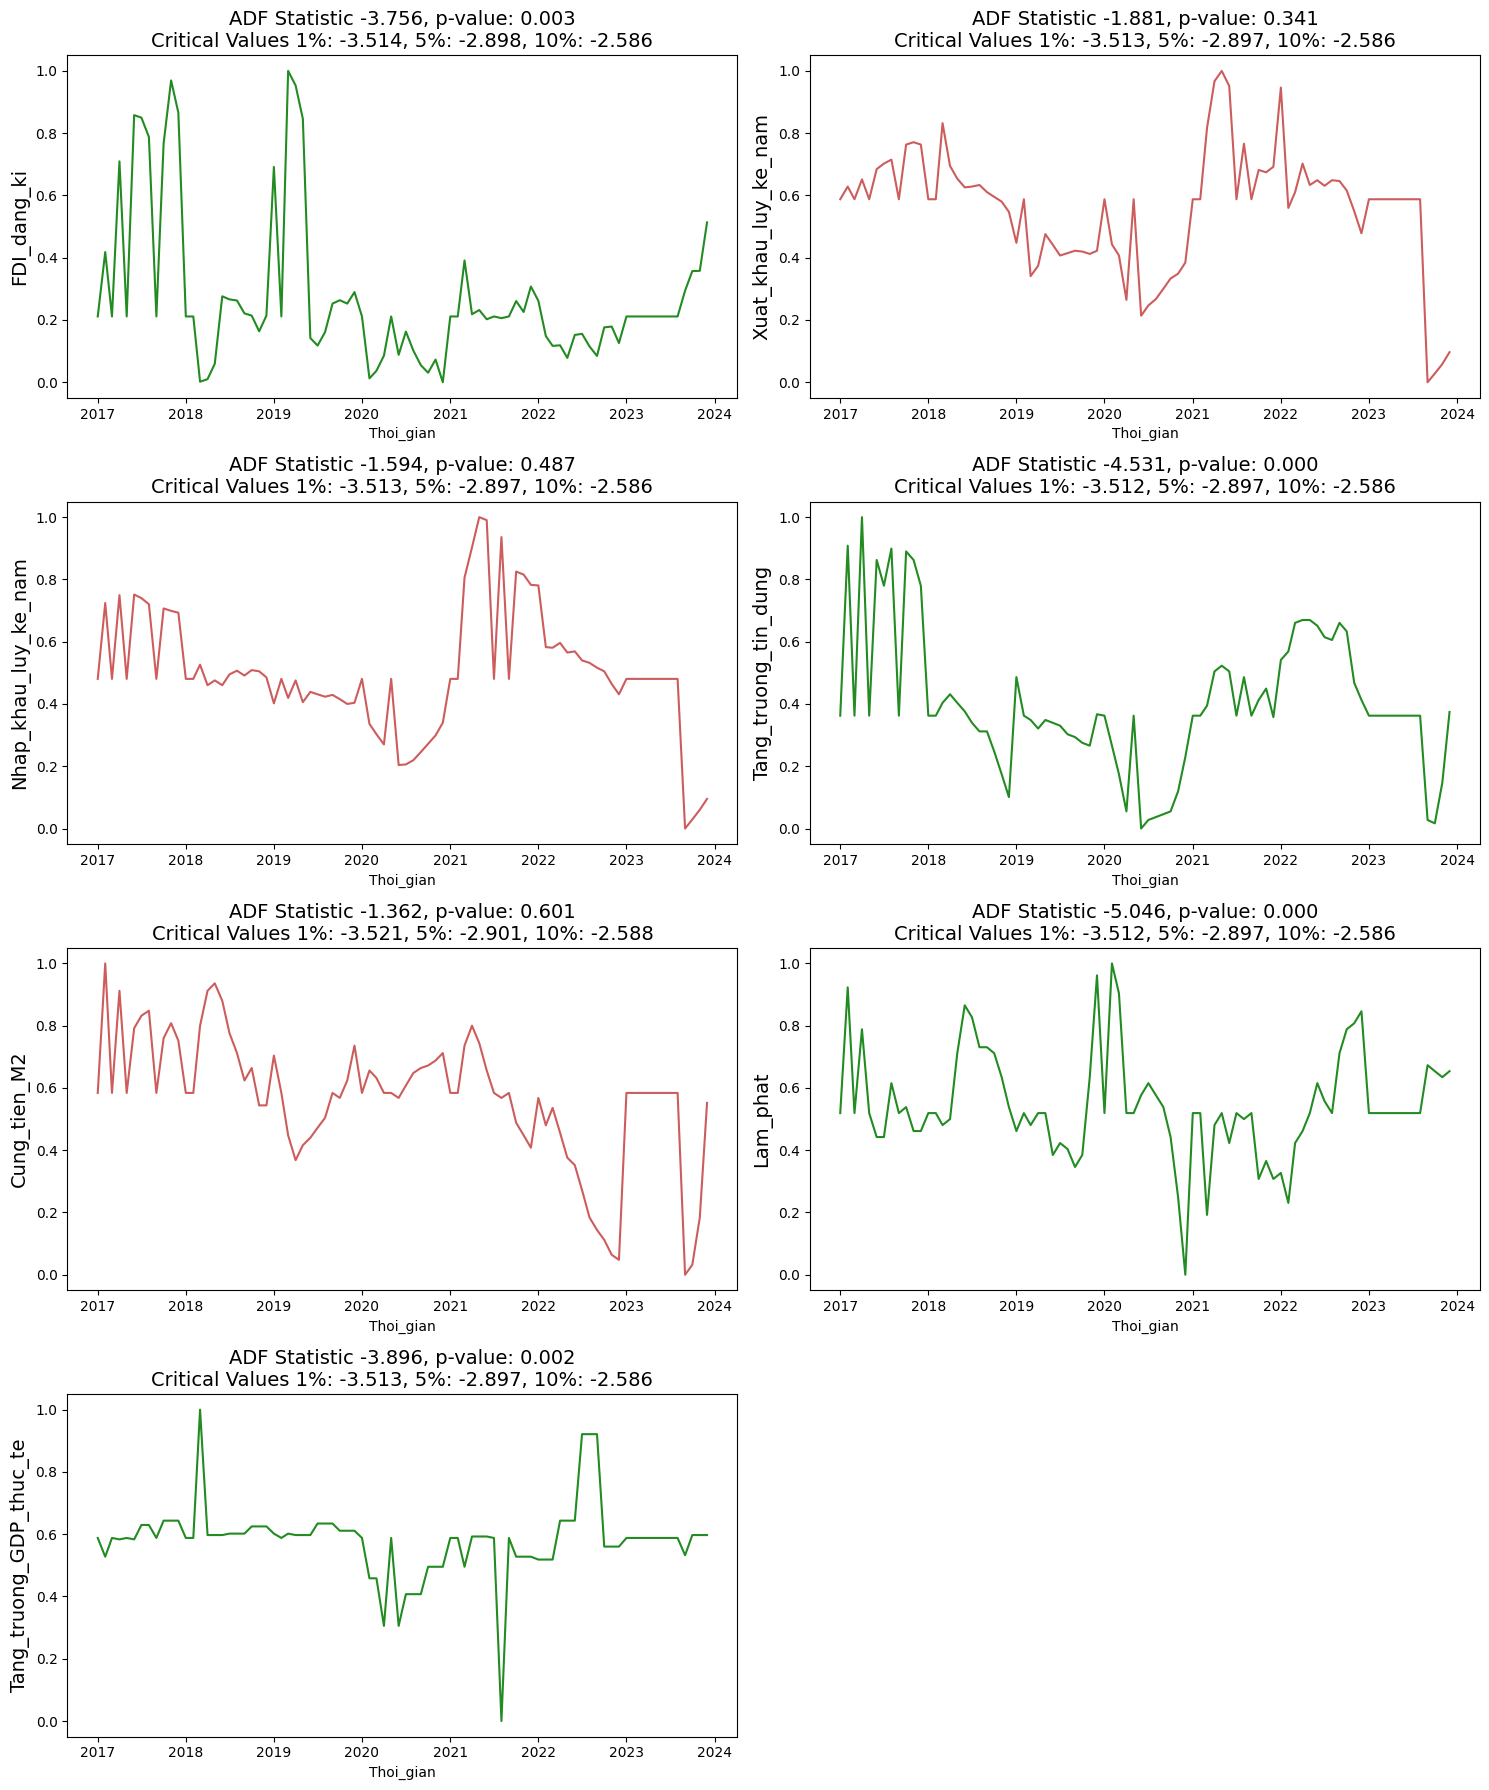

In [313]:
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series) # check adf
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & (adf_stat < crit_val_1):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'gold'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'orange'
    else:
        linecolor = 'indianred'

    sns.lineplot(x=series.index, y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

f, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 18))

columns = ['FDI_dang_ki', 'Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 
           'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    visualize_adfuller_results(data[column], column, ax[row, col])

# Remove empty subplots if has
if len(columns) % 2 != 0:
    f.delaxes(ax[len(columns) // 2, 1])

plt.tight_layout()
plt.show()

=> Mức độ tin cậy về tính dừng của chuỗi thời gian

## 1.3. EDA

### 1.3.2. Corelation matrix

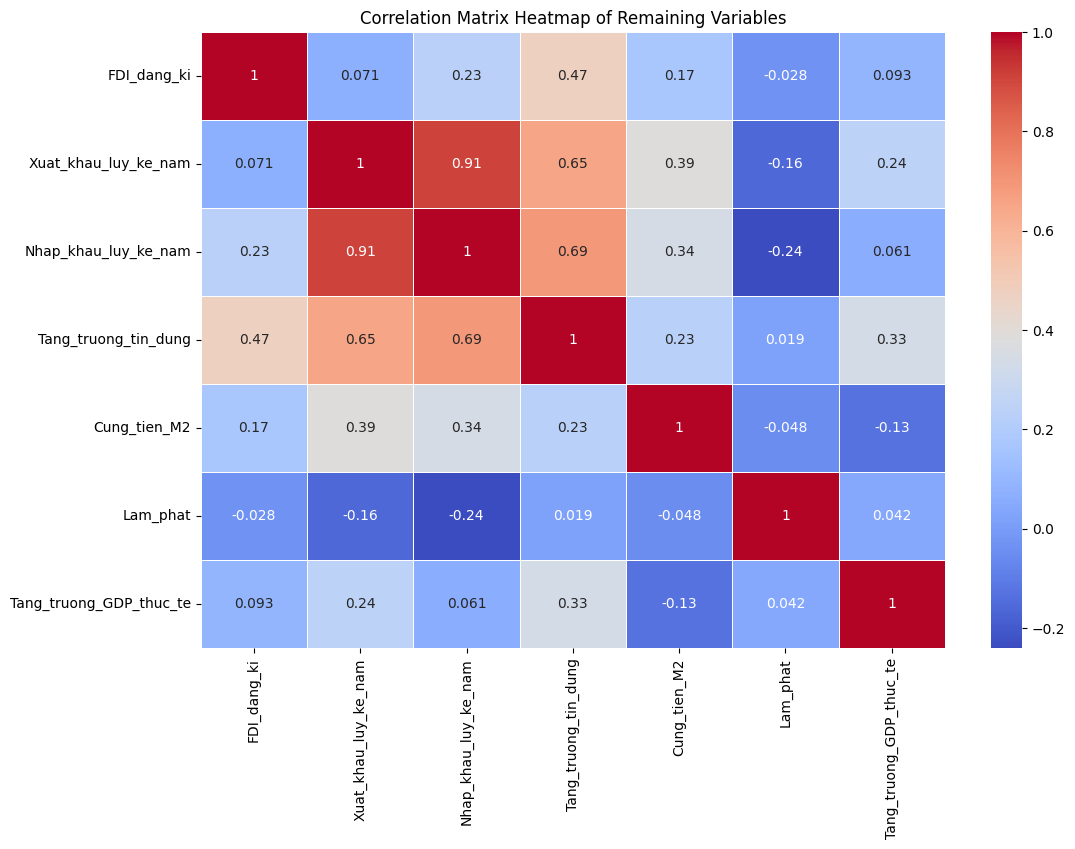

In [314]:
corr_matrix = data.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap of Remaining Variables')
plt.show()

### 1.3.2. Auto correlation

#### Lạm phát

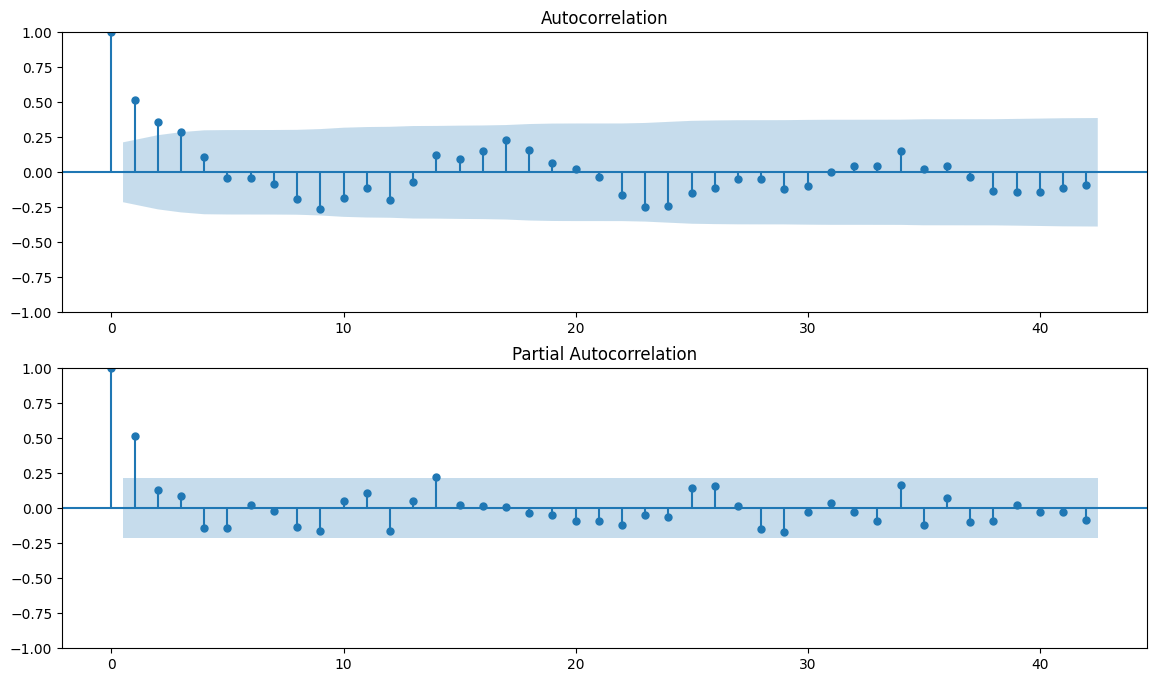

In [315]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

plot_acf(data.Lam_phat,lags=42, ax=ax[0])
plot_pacf(data.Lam_phat,lags=42, ax=ax[1])
plt.show()

=> Có sự tự tương quan đáng kể ở các độ trễ đầu tiên, đặc biệt là độ trễ 1. Điều này cho thấy chuỗi thời gian có thể không hoàn toàn là ngẫu nhiên.

#### Tăng trưởng GDP thực tế

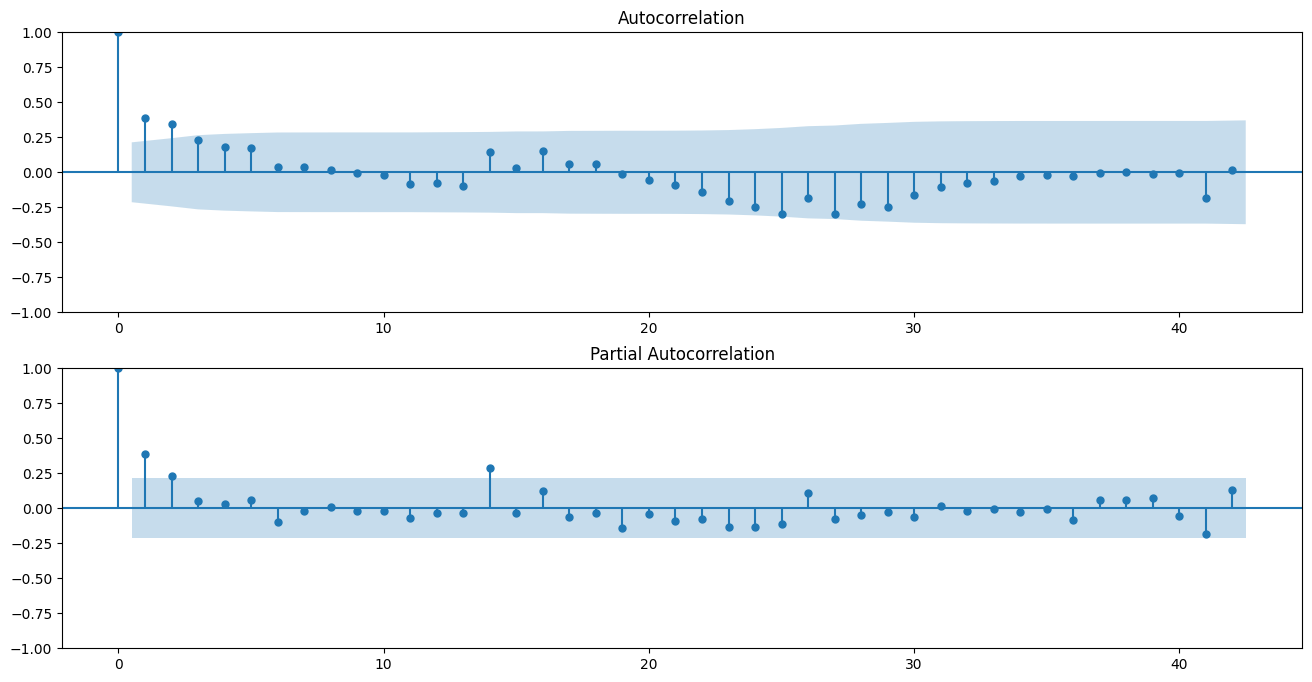

In [316]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[0])
plot_pacf(data.Tang_truong_GDP_thuc_te,lags=42, ax=ax[1])
plt.show()

## 1.4. Model

In [317]:
train_data = data['2017-01-01':'2021-05-01']
test_data = data['2021-06-01':'2023-12-01']

### 1.4.1. ARIMA model

In [318]:
target_1 = 'Lam_phat'
y_train_1 = train_data[target_1]
y_test_1 = test_data[target_1]

target_2 = 'Tang_truong_GDP_thuc_te'
y_train_2 = train_data[target_2]
y_test_2 = test_data[target_2]

#### Lạm phát

In [319]:
model = ARIMA(y_train_1, order=(3, 0, 2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               Lam_phat   No. Observations:                   53
Model:                 ARIMA(3, 0, 2)   Log Likelihood                  24.050
Date:                Fri, 24 May 2024   AIC                            -34.101
Time:                        14:57:58   BIC                            -20.309
Sample:                    01-01-2017   HQIC                           -28.797
                         - 05-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5458      0.056      9.739      0.000       0.436       0.656
ar.L1          0.2332      0.198      1.178      0.239      -0.155       0.621
ar.L2         -0.7180      0.149     -4.811      0.0

Hệ số có ý nghĩa thống kê: Các hệ số AR(2), AR(3), MA(2), và hằng số có ý nghĩa thống kê vì giá trị p của chúng nhỏ hơn 0.05.       
Các hệ số AR(1) và MA(1) không có ý nghĩa thống kê.         
Tính phù hợp của mô hình: AIC, BIC, và HQIC đều rất thấp, cho thấy mô hình này có khả năng phù hợp tốt với dữ liệu.

In [320]:
forecast_1 = model_fit.forecast(steps=len(y_test_1)) 
forecast_1 = forecast_1.rename('Forecast_1')

In [321]:
mse = mean_squared_error(y_test_1, forecast_1)
mae = mean_absolute_error(y_test_1, forecast_1)
rmse = sqrt(mean_squared_error(y_test_1, forecast_1))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0226              
MAE        0.1179              
RMSE       0.1503+0.0000j      


#### Tăng trưởng GDP thực tế

In [322]:
model = ARIMA(y_train_2, order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Tang_truong_GDP_thuc_te   No. Observations:                   53
Model:                      ARIMA(2, 0, 1)   Log Likelihood                  57.471
Date:                     Fri, 24 May 2024   AIC                           -104.942
Time:                             14:57:58   BIC                            -95.091
Sample:                         01-01-2017   HQIC                          -101.154
                              - 05-01-2021                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5746      0.048     11.923      0.000       0.480       0.669
ar.L1          0.5865      0.326      1.798      0.072      -0.053       1.226
ar.L2       

In [323]:
forecast_2 = model_fit.forecast(steps=len(y_test_2)) 
forecast_2 = forecast_2.rename('Forecast_2')
mape_gdp = np.mean(np.abs(forecast_2 - y_test_2)/np.abs(y_test_2))

In [324]:
mse = mean_squared_error(y_test_2, forecast_2)
mae = mean_absolute_error(y_test_2, forecast_2)
rmse = sqrt(mean_squared_error(y_test_2, forecast_2))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0235              
MAE        0.0786              
RMSE       0.1533+0.0000j      


#### Plot the result

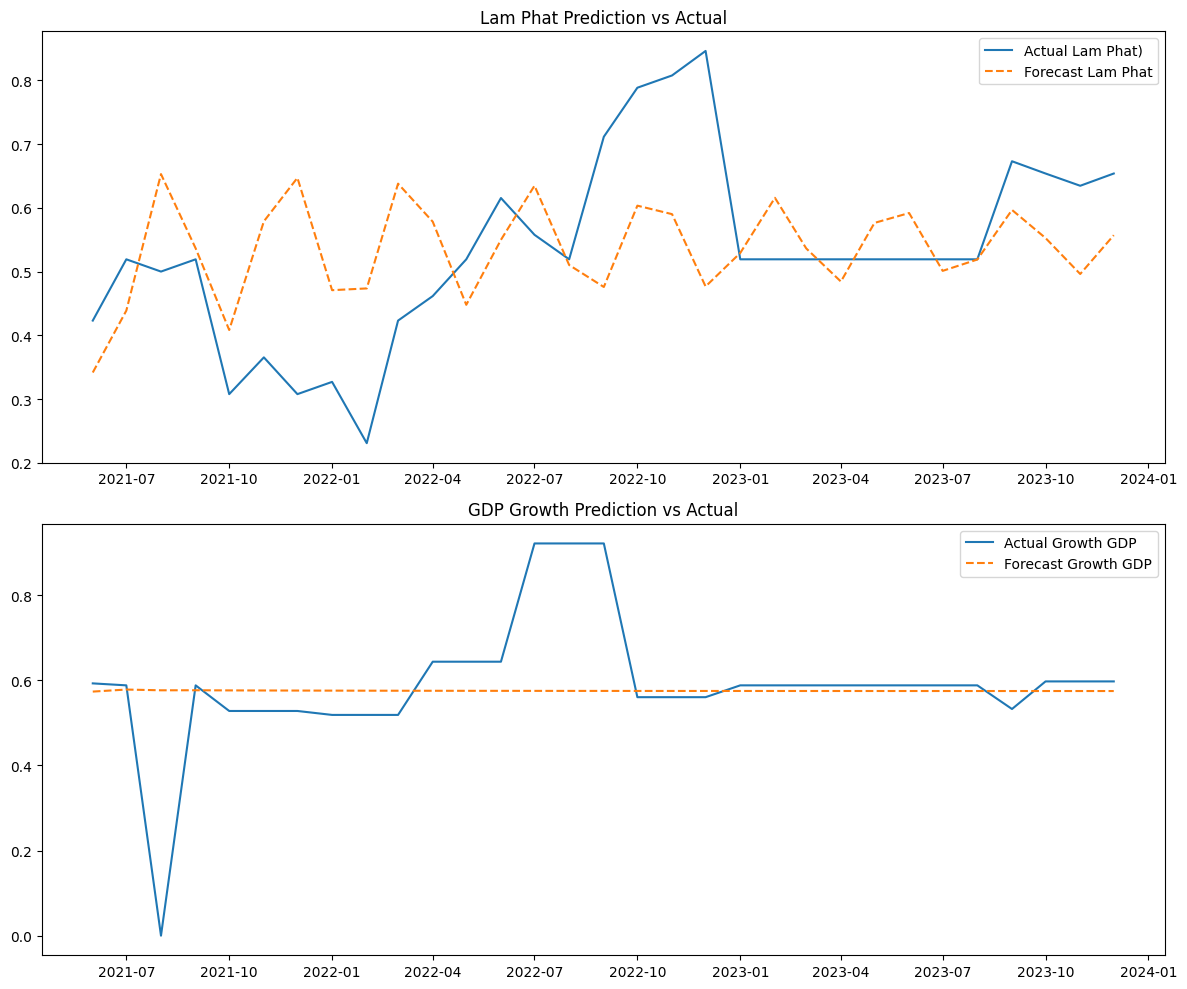

In [325]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

ax[0].plot(y_test_1, label=f'Actual Lam Phat)')
ax[0].plot(forecast_1, label='Forecast Lam Phat', linestyle='--')
ax[0].legend()
ax[0].set_title('Lam Phat Prediction vs Actual')

ax[1].plot(y_test_2, label=f'Actual Growth GDP')
ax[1].plot(forecast_2, label='Forecast Growth GDP', linestyle='--')
ax[1].legend()
ax[1].set_title('GDP Growth Prediction vs Actual')

plt.tight_layout()
plt.show()

## Kết luận 1

### Dự Báo Lạm Phát so với Thực Tế
- **Phù Hợp Trực Quan:** Các giá trị dự báo (đường nét đứt màu cam) nhìn chung theo sát xu hướng của các giá trị thực tế (đường màu xanh) nhưng có một số sai lệch đáng kể.
- **Các Giai Đoạn Sai Lệch:** Có những giai đoạn mà mô hình dự đoán thấp hơn hoặc cao hơn đáng kể so với giá trị thực tế, đặc biệt là vào giữa năm 2022 và giữa năm 2023.
- **Bắt Chụp Mẫu:** Mô hình ARIMA bắt chụp được một số mẫu theo mùa nhưng kém hiệu quả trong các giai đoạn có sự thay đổi đột ngột trong các giá trị thực tế.

### Dự Báo Tăng Trưởng GDP so với Thực Tế
- **Phù Hợp Trực Quan:** Các giá trị dự báo (đường nét đứt màu cam) không theo sát các giá trị thực tế (đường màu xanh). Các dự báo có xu hướng giữ nguyên tương đối phẳng so với các giá trị thực tế, trong khi các giá trị thực tế có sự biến động lớn.
- **Các Giai Đoạn Sai Lệch Lớn:** Mô hình không dự đoán chính xác được đỉnh tăng trưởng GDP vào khoảng giữa năm 2022.
- **Hiệu Suất Tổng Thể:** Mô hình có vẻ không dự đoán tốt cho tăng trưởng GDP, đặc biệt là trong các giai đoạn có biến động lớn.

### Kết Luận Chung
1. **Hiệu Suất Mô Hình:** Mô hình ARIMA hoạt động ở mức trung bình trong việc dự đoán lạm phát, bắt được các xu hướng chung nhưng bỏ lỡ một số thay đổi đột ngột.
2. **Độ Chính Xác Dự Báo:** Đối với tăng trưởng GDP, hiệu suất của mô hình ARIMA không tốt, vì nó không bắt được các biến động lớn và có xu hướng tạo ra dự báo phẳng.
3. **Cải Thiện Tiềm Năng:**
   - **Mô Hình Thay Thế:** Xem xét các mô hình phức tạp hơnn như VARNN cho chuỗi thời gian đa biến

## 1.4.2. VARNN model

In [326]:
features = ['FDI_dang_ki','Xuat_khau_luy_ke_nam', 'Nhap_khau_luy_ke_nam', 'Tang_truong_tin_dung', 'Cung_tien_M2', 'Lam_phat', 'Tang_truong_GDP_thuc_te']
target = ['Tang_truong_tin_dung', 'Lam_phat', 'Tang_truong_GDP_thuc_te']

trainY = train_data[target]
trainX = train_data[features]

testY = test_data[target]
testX = test_data[features]

### Tạo các biến trễ (lagged features) từ một tập dữ liệu gốc
Tạo các biến trễ từ 1 đến 5 kỳ trước đó

In [327]:
p = 5

def create_lagged_features(data, features, p):
    lagged_data = pd.DataFrame(index=data.index)
    for feature in features:
        for lag in range(1, p + 1):
            lagged_data[f'{feature}_lag{lag}'] = data[feature].shift(lag)
    lagged_data.dropna(inplace=True)
    return lagged_data

In [328]:
trainX_lagged = create_lagged_features(trainX, features, p)
testX_lagged = create_lagged_features(testX, features, p)

# Update trainY and testY to match lagged features
trainY = trainY.loc[trainX_lagged.index]
testY = testY.loc[testX_lagged.index]

In [329]:
trainX_lagged.head()

,FDI_dang_ki_lag1,FDI_dang_ki_lag2,FDI_dang_ki_lag3,FDI_dang_ki_lag4,FDI_dang_ki_lag5,Xuat_khau_luy_ke_nam_lag1,Xuat_khau_luy_ke_nam_lag2,Xuat_khau_luy_ke_nam_lag3,Xuat_khau_luy_ke_nam_lag4,Xuat_khau_luy_ke_nam_lag5,...,Lam_phat_lag1,Lam_phat_lag2,Lam_phat_lag3,Lam_phat_lag4,Lam_phat_lag5,Tang_truong_GDP_thuc_te_lag1,Tang_truong_GDP_thuc_te_lag2,Tang_truong_GDP_thuc_te_lag3,Tang_truong_GDP_thuc_te_lag4,Tang_truong_GDP_thuc_te_lag5
Thoi_gian,,,,,,,,,,,,,,,,,,,,,
2017-06-01,0.211331,0.709532,0.211331,0.418165,0.211331,0.587786,0.651399,0.587786,0.628499,0.587786,...,0.519231,0.788462,0.519231,0.923077,0.519231,0.587963,0.583333,0.587963,0.527778,0.587963
2017-07-01,0.857914,0.211331,0.709532,0.211331,0.418165,0.684478,0.587786,0.651399,0.587786,0.628499,...,0.442308,0.519231,0.788462,0.519231,0.923077,0.583333,0.587963,0.583333,0.587963,0.527778
2017-08-01,0.849820,0.857914,0.211331,0.709532,0.211331,0.702290,0.684478,0.587786,0.651399,0.587786,...,0.442308,0.442308,0.519231,0.788462,0.519231,0.629630,0.583333,0.587963,0.583333,0.587963
2017-09-01,0.787770,0.849820,0.857914,0.211331,0.709532,0.715013,0.702290,0.684478,0.587786,0.651399,...,0.615385,0.442308,0.442308,0.519231,0.788462,0.629630,0.629630,0.583333,0.587963,0.583333
2017-10-01,0.211331,0.787770,0.849820,0.857914,0.211331,0.587786,0.715013,0.702290,0.684478,0.587786,...,0.519231,0.615385,0.442308,0.442308,0.519231,0.587963,0.629630,0.629630,0.583333,0.587963


In [330]:
# Convert to numpy arrays for TensorFlow
trainX_lagged = trainX_lagged.to_numpy()
trainY = trainY.to_numpy()
testX_lagged = testX_lagged.to_numpy()
testY = testY.to_numpy()

In [331]:
# Define the number of output variables
num_outputs = len(target)
num_outputs

3

#### Build model

The model consists of two main parts:

- **ffnn_model:** A simple neural network with a Flatten layer to flatten the input data and a Dense layer with 64 neurons and ReLU activation function.

- **var_model:** Another Dense layer to predict the output variables (the number of outputs is determined by num_outputs).

- **CustomModel:** A custom layer defined by inheriting from tf.keras.Model. In the call method, it utilizes ffnn_model to process the input and then uses var_model to make predictions.

In [332]:
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(trainX_lagged.shape[1],)
                            ),  # Flatten the lagged input
    tf.keras.layers.Dense(64, activation='relu'),  # Example number of neurons
])

var_model = tf.keras.layers.Dense(num_outputs)

class CustomModel(tf.keras.Model):
    def __init__(self, ffnn_model, var_model):
        super(CustomModel, self).__init__()
        self.ffnn_model = ffnn_model
        self.var_model = var_model

    def call(self, inputs):
        ffnn_output = self.ffnn_model(inputs)
        var_output = self.var_model(ffnn_output)
        return var_output

Khởi tạo và compile mô hình

In [333]:
custom_model = CustomModel(ffnn_model, var_model)
custom_model.compile(optimizer='adam', loss='mse')

#### Huấn luyện và đánh giá mô hình trên tập dữ liệu kiểm tra

In [334]:
custom_model.fit(trainX_lagged, trainY, verbose=1, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = custom_model.evaluate(testX_lagged, testY)
print(f'Test Loss: {loss}')

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 0.3463 - val_loss: 0.1475
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2221 - val_loss: 0.0939
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1319 - val_loss: 0.0588
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0797 - val_loss: 0.0386
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0493 - val_loss: 0.0293
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0398 - val_loss: 0.0267
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0392 - val_loss: 0.0278
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0451 - val_loss: 0.0302
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0511 - val_loss: 0.0320
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0516 - val_loss: 0.0321
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0492 - val_loss: 0.0309
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0439 - val_loss: 0.0299


### Dự đoán

In [335]:
predictions = custom_model.predict(testX_lagged)

predictions_df = pd.DataFrame(predictions, index=test_data.index[p:], columns=target)

print("Predictions on test data:")
predictions_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Predictions on test data:


,Tang_truong_tin_dung,Lam_phat,Tang_truong_GDP_thuc_te
Thoi_gian,,,
2021-11-01,0.483171,0.665038,0.540914
2021-12-01,0.554453,0.679693,0.624564
2022-01-01,0.572456,0.598316,0.443548
2022-02-01,0.517602,0.641413,0.588007
2022-03-01,0.641840,0.655840,0.647661


#### Plot the result

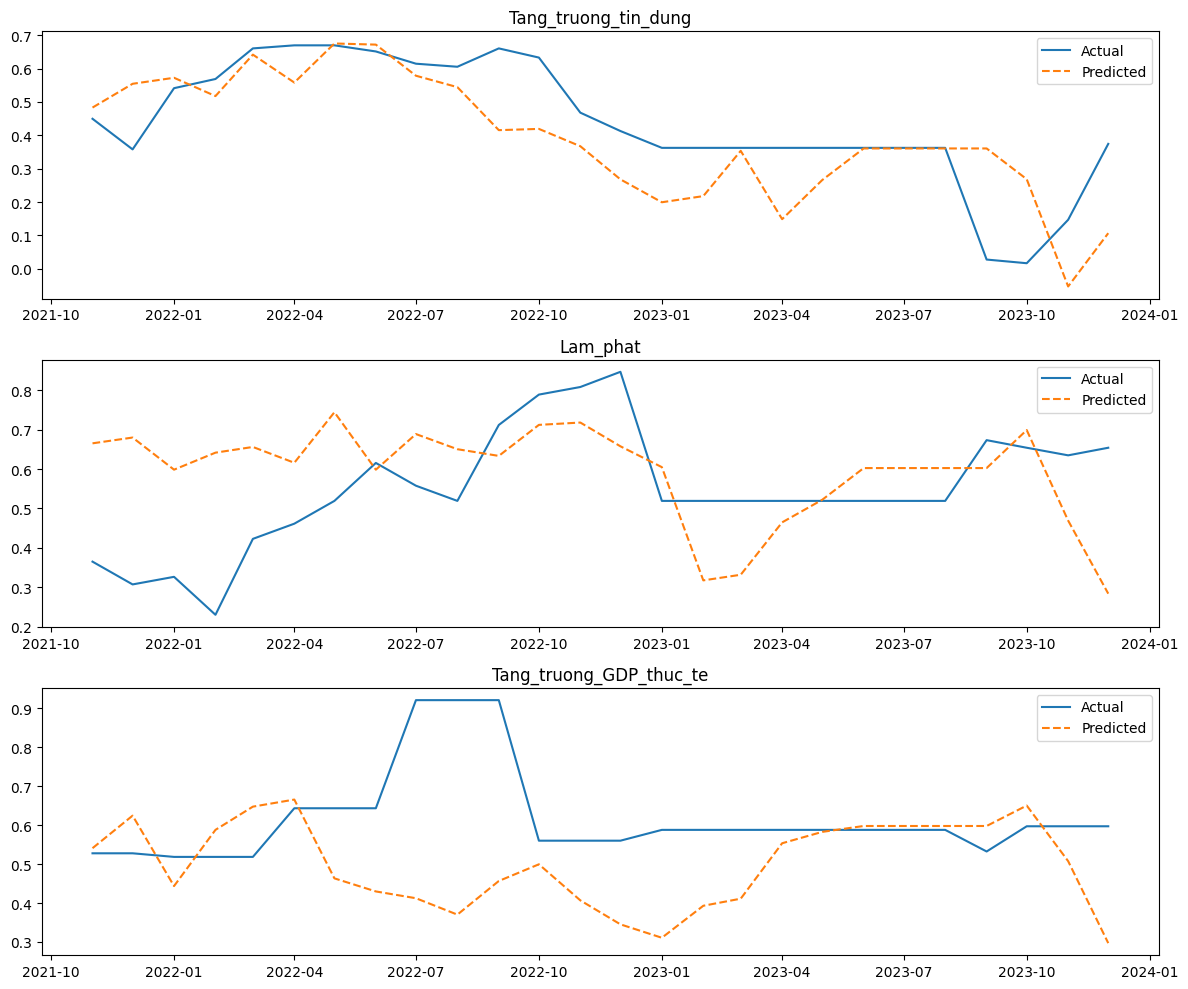

In [336]:
plt.figure(figsize=(12, 10))
for i, col in enumerate(target):
    plt.subplot(len(target), 1, i+1)
    plt.plot(test_data.index[p:], testY[:, i], label='Actual')
    plt.plot(test_data.index[p:], predictions[:, i], label='Predicted', linestyle='--')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

In [337]:
mse = mean_squared_error(testY, predictions)
mae = mean_absolute_error(testY, predictions)
rmse = sqrt(mean_squared_error(testY, predictions))

print(f"Model Evaluation Metrics:")
print(f"{'Metric':<10} {'Value':<20}")
print(f"{'-'*30}")
print(f"{'MSE':<10} {mse:<20.4f}")
print(f"{'MAE':<10} {mae:<20.4f}")
print(f"{'RMSE':<10} {rmse:<20.4f}")

Model Evaluation Metrics:
Metric     Value               
------------------------------
MSE        0.0356              
MAE        0.1416              
RMSE       0.1886+0.0000j      


## Kết luận 2

### Kết Luận từ Hình trên:
Khi sử dụng mô hình VARNN (Vector Autoregression Neural Network) để dự đoán ba chỉ số: Tăng Trưởng Tín Dụng, Lạm Phát, và Tăng Trưởng GDP Thực Tế. Dựa trên các biểu đồ và các chỉ số đánh giá mô hình, ta nhận thấy:

#### 1. Tăng Trưởng Tín Dụng
- **Phù Hợp Trực Quan:** Dự báo (đường nét đứt màu cam) nhìn chung theo xu hướng của giá trị thực tế (đường màu xanh), nhưng có một số giai đoạn dự báo sai lệch đáng kể, đặc biệt là vào cuối năm 2022 và đầu năm 2023.
- **Giai Đoạn Sai Lệch:** Mô hình có xu hướng dự báo thấp hơn giá trị thực tế trong nhiều giai đoạn.

#### 2. Lạm Phát (Lam Phat)
- **Phù Hợp Trực Quan:** Dự báo và giá trị thực tế có xu hướng tương đồng, nhưng mô hình vẫn chưa bắt kịp những biến động lớn, đặc biệt là các đỉnh và đáy.
- **Giai Đoạn Sai Lệch:** Mô hình có vẻ bị trễ trong việc dự đoán các biến động lớn, đặc biệt vào giữa năm 2022 và giữa năm 2023.

#### 3. Tăng Trưởng GDP Thực Tế
- **Phù Hợp Trực Quan:** Dự báo không theo sát giá trị thực tế. Các dự báo có xu hướng phẳng so với các biến động lớn của giá trị thực tế, đặc biệt là các đỉnh cao vào giữa năm 2022.
- **Giai Đoạn Sai Lệch:** Mô hình không dự đoán chính xác các biến động lớn, đặc biệt là sự sụt giảm và tăng trưởng đột biến.

### Chỉ Số Đánh Giá Mô Hình
- **MSE (0.0377):** Lỗi bình phương trung bình khá nhỏ, cho thấy mô hình không có nhiều sai số lớn.
- **MAE (0.1453):** Lỗi tuyệt đối trung bình cũng tương đối thấp, nhưng cao hơn so với MSE, cho thấy có một số sai lệch đáng kể.

### Kết Luận Chung
1. **Hiệu Suất Mô Hình:** Mô hình VARNN hoạt động khá tốt trong việc dự đoán các xu hướng chung nhưng gặp khó khăn trong việc bắt chụp các biến động lớn và đột ngột.
2. **Độ Chính Xác Dự Báo:** Mô hình dự đoán tốt hơn cho lạm phát so với tăng trưởng tín dụng và GDP, nhưng vẫn có sự sai lệch đáng kể trong một số giai đoạn.
3. **Cải Thiện Tiềm Năng:**
   - **Tinh Chỉnh Mô Hình:** Tinh chỉnh các tham số của mô hình VARNN có thể cải thiện hiệu suất.

Nhìn chung, mô hình VARNN cung cấp một nền tảng khá tốt cho dự báo các chỉ số kinh tế, nhưng vẫn cần được cải thiện để bắt kịp các biến động lớn và đột ngột trong dữ liệu thực tế.